## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df['converted'] == 1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
len(df.query('group == "control" and landing_page == "new_page"')), len(df.query('group == "treatment" and landing_page == "old_page"'))

(1928, 1965)

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  


In [8]:
indexes_drop = df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').index
df2 = df.drop(indexes_drop)
len(df2)


290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Further explore df2 and clean the dataset.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. What are the **user_id** repeated in **df2**?

In [11]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep this dataframe as **df2**.

In [13]:
df2.drop(2893,inplace=True)

`4.` Use **df2** to find the conversion rate for overall users and for each group.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
(df2['converted'] == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_old_actual = (df2.query('group == "control"').converted == 1).mean()

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_new_actual = (df2.query('group == "treatment"').converted == 1).mean()

d. What is the probability that an individual received the new page?

In [17]:
(df2["landing_page"] == "new_page").mean()

0.5000619442226688

**According to what we have as result above, I don't think there is sufficient evidence to conclude that the new treatment page leads to more conversions. Based on the sample data, the conversion rate for the new page is even lower than the old page.**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, I will make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be?  

**Null Hypothesis**:        p_new is not greater than p_old  
**Alternative Hypothesis**: p_new is greater than p_old

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1,p_new,n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1,p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

-0.0025970393396526348

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one bove.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  

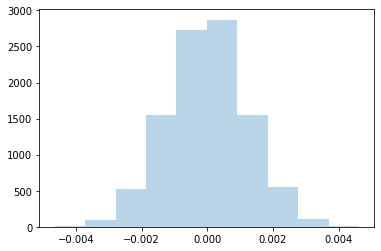

In [26]:
plt.hist(p_diffs, alpha = 0.3);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_diffs > p_new_actual - p_old_actual).mean()

0.9037

**In part j, I just computed the probability of getting the sample statistics or more extreme values if null hypothesis is true. This is called p-value in scientific studies. If this value is less than significance level, then there is a difference between conversion rate of the new and that of old pages.**

l. We could also use a built-in to achieve similar results.  

In [28]:
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"').converted == 1)
convert_new = sum(df2.query('group == "treatment"').converted == 1)
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))

m. Now use `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
from statsmodels.stats.proportion import proportions_ztest
np.array([convert_new,convert_old])
stat, pval = proportions_ztest(np.array([convert_old,convert_new]),np.array([n_old,n_new]),alternative = 'smaller')
stat, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is 1.31, which is smaller than the z score of significance level of 0.05. p-value is as high as 0.905, which shows we are not confident to reject null hypothesis. This result is pretty close to the findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**The result is binary, we should perform logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [31]:
# Add intercept to df2 for regression
df2['intercept'] = 1

In [32]:
# Add dummy variable for page
page_dum = pd.get_dummies(df2['group'])
df2['ab_page'] = page_dum['treatment']

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import my regression model.  Instantiate the model, and fit the model using the two columns I created in part **b.** to predict whether or not an individual converts.

In [34]:
mol = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
res = mol.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:04:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of this model below.

In [35]:
# Analyze ab_page coefficient
1/np.exp(-0.0150)

1.015113064615719

**Summary**  
According to the coefficient of ab_page, old_page is more likely to lead conversion compared to new_page. However, the p-value is 0.190, which is not very significant. 

e. What is the p-value associated with **ab_page**? Why does it differ from the value I found in **Part II**?<br><br>

**The p-value is 0.190 which is much more lower than the p-value we calculated in Part II. The reason why it differs from the value above is that null and alternative hypothesis are different. The null hypothesis in Part II is conversion rate of new_page is not greater than that of old_page. The null hypothesis for logistic regression is that the coefficient of ab_page equals to zero(which means it has no effect on output.)**

f. Now, I'm considering other things that might influence whether or not an individual converts.  Why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into my regression model?

**It's a good idea to consider other factors to add into the regression model because more information will be given to make the model more accurate. However, adding too many terms may result in overfitting.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together my datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [36]:
# Read in the countries.csv file
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Check # of unique user_id in country dataset
country.user_id.nunique()

290584

In [38]:
# Merge with original dataset
df_new = df2.merge(country, on = 'user_id', how = 'inner')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
# Create dummy variables for country info
cty = pd.get_dummies(df_new['country'])
df_new[['CA','UK']] = cty[['CA','UK']]
df_new.drop('country', axis = 1,inplace=True)
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0


In [40]:
# Run Logistic Regression based on country info and ab_page
mol1 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','CA','UK']])
res1 = mol1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        17:04:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Model Summary**:  
In this model adding country info as dummy variables, 'US' is baseline. The result shows that users from Canada is less likely to be converted compared to US. In contrast, UK users tend to have higher conversion rate than US. The rank of conversion rate from high to low is: UK, US, CA.

h. Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [41]:
# Include interactions between country and page
df_new['CA_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_page'] = df_new['UK']*df_new['ab_page']
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,CA_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,0,0


In [42]:
# Fit a new model to include the new columns
mod3 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK','UK_page','CA_page']])
res3 = mod3.fit()
res3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:               3.482e-05
Time:                        17:04:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

**Model Summary**:  
The p-value is pretty high for 'CA' and 'UK'. The coefficient for UK_page and CA_page shows conversion is more likely for UK users with new page than that of US users with new page. However, conversions for US users with new page is more likely than CA users with new page.

<a id='conclusions'></a>
## Conclusions

In this project, I conducted A/B testing via three methodologies:  
- Hypothesis Testing by simulating random sampling  
- Hypothesis Testing by proportions_ztest function in stats module  
- Logistic Regression

**Result**   
Through the analyses, I found that p-values are always bigger than 0.05, which is the significance level specified in the beginning. That means we are not able to reject the null hypothesis to state that the new page has higher conversion rate compared to the old page. 

**Recommendation**  
Therefore, I will recommend the e-commerce site not to launch the new page. 
